# Relationships between variables

So far we have only looked at one variable at a time.
In this chapter we look at relationships between variables.
Two variables are related if knowing one gives you information about the other.
For example, height and weight are related; people who are taller tend to be heavier.
Of course, it is not a perfect relationship: there are short heavy people and tall light ones.
But if you are trying to guess someone's weight, you will be more accurate if you know their height than if you don't.

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
from os.path import basename, exists


def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve

        local, _ = urlretrieve(url, filename)
        print("Downloaded " + local)


download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/thinkstats.py")

<IPython.core.display.Javascript object>

In [3]:
try:
    import empiricaldist
except ImportError:
    !pip install empiricaldist

<IPython.core.display.Javascript object>

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from thinkstats import decorate

<IPython.core.display.Javascript object>

## Scatter Plots

If you meet someone who is unusually good at math, do you expect their verbal skills to be better or worse than average?
On one hand, you might imagine that people specialize in one area or the other, so someone who excels at one might be less good at the other.
On the other hand, you might expect someone who is generally smart to be above average in both areas.
Let's find out which is true.

We'll use data from the National Longitudinal Survey of Youth 1997 (NLSY97), which "follows the lives of a sample of 8,984 American youth born between 1980-84". 
The public data set includes the participants' scores on several standardized tests, including the tests most often used in college admissions, the SAT and ACT.
Because test-takers get separate scores for the math and verbal sections, we can use this data to explore the relationship between mathematical and verbal ability.

I used the NLS Investigator to create excerpt that contains the variables I'll use for this analysis.
With their permission, I can redistribute this except. 
We can use `read_csv` to read the data and `replace` to replace the special codes for missing data with `np.nan`.

In [5]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/nlsy97-extract.csv.gz")

<IPython.core.display.Javascript object>

In [6]:
missing_codes = [-1, -2, -3, -4, -5]
nlsy = pd.read_csv("nlsy97-extract.csv.gz").replace(missing_codes, np.nan)
nlsy.shape

(8984, 34)

<IPython.core.display.Javascript object>

In [7]:
xvar = "R1318200"
yvar = "U4949700"

valid = nlsy.dropna(subset=[xvar, yvar])
np.corrcoef(valid[xvar], valid[yvar])

array([[1.        , 0.30338587],
       [0.30338587, 1.        ]])

<IPython.core.display.Javascript object>

In [8]:
nlsy.head()

,R0000100,R0490200,R0536300,R0536401,R0536402,R1235800,R1318200,R1482600,R3961900,R3989200,...,R9872200,R9872300,R9872400,S1552700,U0008900,U1845500,U3444000,U4949700,Z9083800,Z9083900
0,1,NaN,2,9,1981,1,NaN,4,NaN,NaN,...,293.0,250.0,333.0,NaN,120000.0,NaN,NaN,NaN,16.0,4.0
1,2,NaN,1,7,1982,1,145.0,2,NaN,NaN,...,114.0,230.0,143.0,NaN,98928.0,116000.0,188857.0,180000.0,14.0,2.0
2,3,NaN,2,9,1983,1,82.0,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,75000.0,16.0,4.0
3,4,NaN,2,2,1981,1,NaN,2,NaN,NaN,...,195.0,230.0,216.0,NaN,85000.0,45000.0,NaN,NaN,13.0,2.0
4,5,NaN,1,10,1982,1,NaN,2,NaN,NaN,...,293.0,230.0,231.0,NaN,210000.0,212000.0,NaN,240000.0,12.0,2.0


<IPython.core.display.Javascript object>

The `DataFrame` contains one row for each of the 8984 participants in the survey and one column for each of the 34 variables I selected.
The column names don't mean much by themselves, but we can replace the ones we use with more interpretable names.

In [9]:
nlsy["sat_verbal"] = nlsy["R9793800"]
nlsy["sat_math"] = nlsy["R9793900"]

<IPython.core.display.Javascript object>

Both columns contain a few values less than 200, which is not possible because 200 is the lowest score, so we'll replace them with `np.nan`.

In [10]:
columns = ["sat_verbal", "sat_math"]

for column in columns:
    invalid = nlsy[column] < 200
    nlsy.loc[invalid, column] = np.nan

<IPython.core.display.Javascript object>

Next we'll use `dropna` to select only rows where both scores are valid.

In [11]:
nlsy_valid = nlsy.dropna(subset=columns).copy()
nlsy_valid.shape

(1398, 36)

<IPython.core.display.Javascript object>

SAT scores are standardized so the mean is 500 and the standard deviation is 100.
In the NLSY sample, the means and standard deviations are close to these values.

In [12]:
sat_verbal = nlsy_valid["sat_verbal"]
sat_verbal.mean(), sat_verbal.std()

(501.80972818311875, 108.36562024213643)

<IPython.core.display.Javascript object>

In [13]:
sat_math = nlsy_valid["sat_math"]
sat_math.mean(), sat_math.std()

(503.0829756795422, 109.8329973731453)

<IPython.core.display.Javascript object>

Now, to see whether there is a relationship between these variables, let's look at a **scatter plot**.

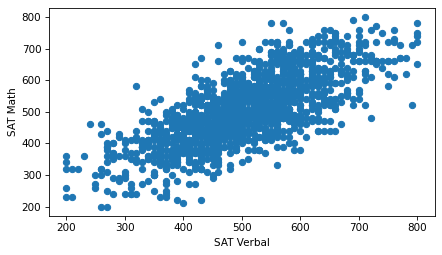

<IPython.core.display.Javascript object>

In [14]:
plt.scatter(sat_verbal, sat_math)

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

Using the default options of the `scatter` function, we can see the general shape of the relationship.
People who do well on one section of the test tend to do better on the other, too.

However, this version of the figure is **overplotted**, which means there are a lot of overlapping points, which can create a misleading impression of the relationship.
The center, where the density of points is highest, is not as dark as it should be; by comparison, the extreme values are darker than they should be.
Overplotting tend to give too much visual weight to outliers.

We can improve the plot by reducing the marker size so they overlap less.

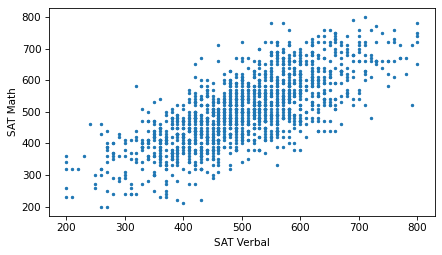

<IPython.core.display.Javascript object>

In [15]:
plt.scatter(sat_verbal, sat_math, s=5)

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

Now we can see that the markers are aligned in rows and columns, because scores are rounded off to the nearest multiple of 10.
Some information is lost in the process.

We can't get that information back, but we can minimize the effect on the scatter plot by **jittering** the data, which means adding random noise to reverse the effect of rounding off.
The following function takes a sequence and jitters it by adding random values from a normal distribution with mean 0 and the given standard deviation.

In [16]:
def jitter(seq, std=1):
    """Jitters the values by adding random Gaussian noise.

    seq: sequence of numbers
    std: standard deviation of the added noise

    returns: new Numpy array
    """
    n = len(seq)
    return np.random.normal(0, std, n) + seq

<IPython.core.display.Javascript object>

If we jitter the scores with a standard deviation of 3, the rows and columns are no longer visible in the scatter plot.

In [17]:
sat_verbal_jittered = jitter(sat_verbal, 3)
sat_math_jittered = jitter(sat_math, 3)

<IPython.core.display.Javascript object>

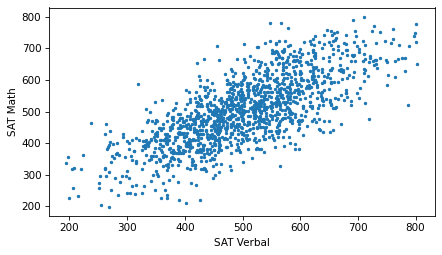

<IPython.core.display.Javascript object>

In [18]:
plt.scatter(sat_verbal_jittered, sat_math_jittered, s=5)

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

Jittering reduces the visual effect of rounding and makes the shape of the relationship clearer.
But in general you should only jitter data for purposes of visualization and avoid using jittered data for analysis.

In this example, even after adjusting the marker size and jittering the data, there is still some overplotting.
So let's try one more thing: we can use the `alpha` parameter to make the markers partly transparent.

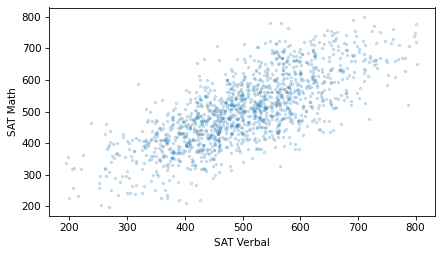

<IPython.core.display.Javascript object>

In [19]:
plt.scatter(sat_verbal_jittered, sat_math_jittered, s=5, alpha=0.2)

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

With transparency, overlapping data points look darker, so darkness is proportional to density.

Although scatter plots are a simple and widely-used visualization, they can be hard to get right.
In general, it takes some trial and error to adjust marker sizes, transparency, and jittering to find the best visual representation of the relationship between variables.

## Decile Plots

Scatter plots provide a general impression of the relationship between variables, but there are other visualizations that provide more insight into the nature of the relationship.
One of them is a **decile plot**.

To generate a decile plot, we'll sort the respondents by verbal scores and divide them into 10 groups, called **deciles**.
We can use the `qcut` method to compute the deciles and add the results as a column in the `DataFrame`.

In [20]:
nlsy_valid["decile"] = pd.qcut(nlsy_valid["sat_verbal"], 10, labels=False) + 1
nlsy_valid["decile"].value_counts().sort_index()

decile
1     142
2     150
3     139
4     140
5     159
6     130
7     148
8     121
9     138
10    131
Name: count, dtype: int64

<IPython.core.display.Javascript object>

For each respondent, the `decile` column indicates which decile their verbal score falls in.
The number of respondents in each decile is roughly equal.

Now we can use the `groupby` method to divide the `DataFrame` into groups by `decile`.

In [21]:
df_groupby = nlsy_valid.groupby("decile")
df_groupby

<IPython.core.display.Javascript object>

The result is a `DataFrameGroupBy` object that represents the groups.
We can select the `sat_math` column from it.

In [22]:
series_groupby = df_groupby["sat_math"]
series_groupby

<IPython.core.display.Javascript object>

The result is a `SeriesGroupBy` object that represents the math scores in each decile.
We can use the `quantile` function to compute the 10th, 50th, and 90th percentiles in each group.

In [23]:
low = series_groupby.quantile(0.1)
median = series_groupby.quantile(0.5)
high = series_groupby.quantile(0.9)

<IPython.core.display.Javascript object>

A decile plot shows these percentiles for each decile group.
In the following figure, the line shows the median and the shaded region shows the area between the 10th and 90th percentiles.

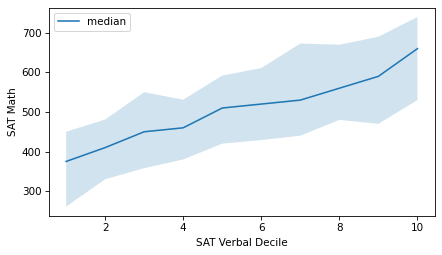

<IPython.core.display.Javascript object>

In [24]:
xs = low.index

plt.fill_between(xs, low, high, alpha=0.2)
plt.plot(xs, median, color="C0", label="median")

decorate(xlabel="SAT Verbal Decile", ylabel="SAT Math")

As an alternative, we can compute the median verbal score in each group and plot those values on the x-axis, rather than the decile numbers. 

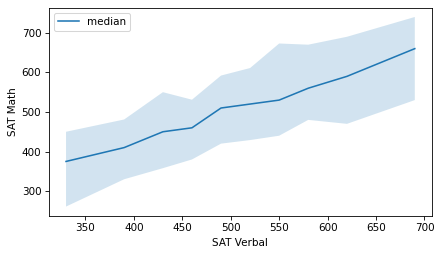

<IPython.core.display.Javascript object>

In [25]:
xs = df_groupby["sat_verbal"].median()

plt.fill_between(xs, low, high, alpha=0.2)
plt.plot(xs, median, color="C0", label="median")

decorate(xlabel="SAT Verbal", ylabel="SAT Math")

It looks like the relationship between these variables is linear -- that is, each increase the median verbal scores corresponds to a roughly equal increase in median math scores.

More generally, we could divide the respondents into any number of groups, not necessarily 10, and we could compute other summary statistics in each group, not just these percentiles.

## Correlation

When the NLSY participants were in 9th grade, many of them took the mathematics section of the Peabody Individual Achievement Test (PIAT).
Let's give the column that contains the results a more interpretable name.

In [110]:
nlsy["piat_math"] = nlsy["R1318200"]
nlsy["piat_math"].describe()

count    6044.000000
mean       93.903706
std        14.631148
min        55.000000
25%        84.000000
50%        92.000000
75%       103.000000
max       145.000000
Name: piat_math, dtype: float64

<IPython.core.display.Javascript object>

Here's what the distribution of scores looks like.

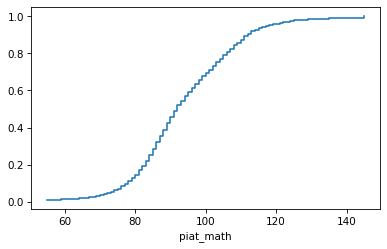

<IPython.core.display.Javascript object>

In [109]:
cdf_piat_math = Cdf.from_seq(nlsy["piat_math"])
cdf_piat_math.step()

Students who do well on the PIAT in 9th grade are likely to do well on the SAT math second in 12th grade.
For the NLSY participants who took both tests, the following scatter plot shows the relationship between their scores.

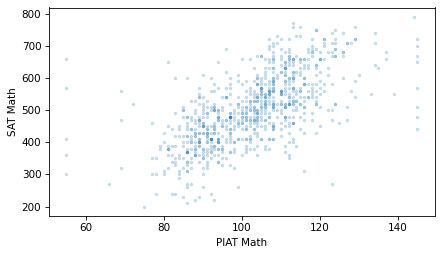

<IPython.core.display.Javascript object>

In [27]:
from thinkstats import scatter

scatter(nlsy, "piat_math", "sat_math")

decorate(xlabel="PIAT Math", ylabel="SAT Math")

Students who do well on the PIAT are also likely to do well on the SAT verbal.
The following figure shows the relationship between the scores.

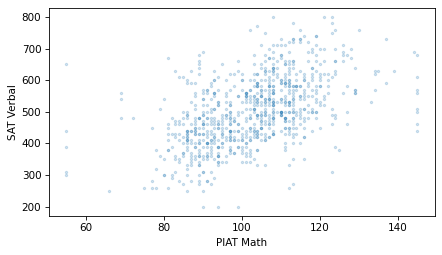

<IPython.core.display.Javascript object>

In [28]:
scatter(nlsy, "piat_math", "sat_verbal")

decorate(xlabel="PIAT Math", ylabel="SAT Verbal")

Comparing the scatter plots, the points in the first figure might be more compact, and the points in the second figure more dispersed.
If so, that means that the PIAT math scores predict SAT math scores more accurately than they predict SAT verbal scores -- and it makes sense if they do.

To quantify the strength of these relationships, we can use the **Pearson correlation coefficient**, often just called "correlation".
To understand correlation, let's start with standardization.

To standardize a variable, we subtract off the mean and divide through by the standard deviation, as in this function.

In [29]:
def standardize(xs):
    """Standardizes a sequence of numbers.

    xs: sequence of numbers

    returns: NumPy array
    """
    return (xs - np.mean(xs)) / np.std(xs)

<IPython.core.display.Javascript object>

To show how it's used, we'll select the rows where `piat_math` and `sat_math` are valid.

In [30]:
valid = nlsy.dropna(subset=["piat_math", "sat_math"])
piat_math = valid["piat_math"]
sat_math = valid["sat_math"]

<IPython.core.display.Javascript object>

And standardize the PIAT math scores.

In [31]:
piat_math_standard = standardize(piat_math)
np.mean(piat_math_standard), np.std(piat_math_standard)

(-2.4321756236287047e-16, 1.0)

<IPython.core.display.Javascript object>

The results are **standard scores**, also called "z-scores".
By design, the mean of the standard scores is close to 0 and the standard deviation is close to 1.

Let's also standardize the SAT math scores.

In [32]:
sat_math_standard = standardize(sat_math)
np.mean(sat_math_standard), np.std(sat_math_standard)

(-1.737268302591932e-16, 0.9999999999999998)

<IPython.core.display.Javascript object>

The following figure shows sequences of these scores for the first 100 participants.

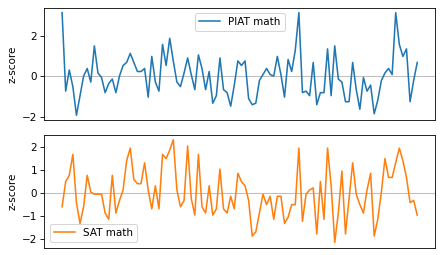

<IPython.core.display.Javascript object>

In [33]:
plt.subplot(2, 1, 1)
plt.axhline(0, color="gray", lw=1, alpha=0.5)
plt.plot(piat_math_standard.values[:100], label="PIAT math")
decorate(ylabel="z-score", xticks=[])

plt.subplot(2, 1, 2)
plt.axhline(0, color="gray", lw=1, alpha=0.5)
plt.plot(sat_math_standard.values[:100], label="SAT math", color="C1")
decorate(ylabel="z-score", xticks=[])

These variables are clearly related: when one is above the mean, the other is likely to be above the mean, too.
To quantify the strength of this relationship, we'll multiply the standard scores element-wise and compute the mean of the products.

When both scores are positive, their product is positive, so it tends to increase the mean.
And when both scores are negative, their product is positive, so it also tends to increase the mean.
When the scores have opposite signs, the product is negative, so it decreases the mean.
As a result, the mean of the product measures the similarity between the sequences.

In [34]:
np.mean(piat_math_standard * sat_math_standard)

0.639735816517885

<IPython.core.display.Javascript object>

The result, which is about 0.64, is the correlation coefficient.
Here's one way to interpret it: if someone's PIAT math score is 1 standard deviation above the mean, we expect their SAT math score to be 0.64 standard deviations above the mean, on average.

The result is the same if we multiply the elements in the other order.

In [35]:
np.mean(sat_math_standard * piat_math_standard)

0.639735816517885

<IPython.core.display.Javascript object>

So the correlation coefficient is symmetric: if someone's SAT math score is 1 standard deviation above the mean, we expect their PIAT math score to be 0.64 standard deviations above the mean, on average.

Correlation is a commonly-used statistic, so NumPy provides a function that computes it.

In [36]:
np.corrcoef(piat_math, sat_math)

array([[1.        , 0.63973582],
       [0.63973582, 1.        ]])

<IPython.core.display.Javascript object>

The result is a **correlation matrix**, with one row and one column for each variable.
The value in the upper left is the correlation of `piat_math` with itself.
The value in the lower right is the correlation of `sat_math` with itself.
The correlation of any variable with itself is 1, which indicates perfect correlation.

The values in the upper right and lower left are the correlation of `piat_math` with `sat_math` and the correlation of `sat_math` with `piat_math`, which are necessarily equal. 

`thinkstats` provides a `corrcoef` function that takes a `DataFrame` and two column names, selects the rows where both columns are valid, and computes their correlation.

In [37]:
from thinkstats import corrcoef

corrcoef(nlsy, "piat_math", "sat_math")

0.6397358165178849

<IPython.core.display.Javascript object>

We can use this function to compute the correlation of `piat_math` and `sat_verbal`.

In [38]:
corrcoef(nlsy, "piat_math", "sat_verbal")

0.509413914696731

<IPython.core.display.Javascript object>

The correlation is about 0.51, so if someone's PIAT math score is one standard deviation above the mean, we expect their SAT verbal score to be 0.51 standard deviations above the mean, on average.

As we might expect, PIAT math scores predict SAT math scores better than they predict SAT verbal score -- but not by very much.

## Strength of Correlation

As you look at more scatter plots, you will get a sense of what different correlations look like.
To help you develop this sense, the following figure shows scatter plots for randomly-generated data with different correlations.

In [39]:
np.random.seed(17)
xs = np.random.normal(size=300)
ys = np.random.normal(size=300)

<IPython.core.display.Javascript object>

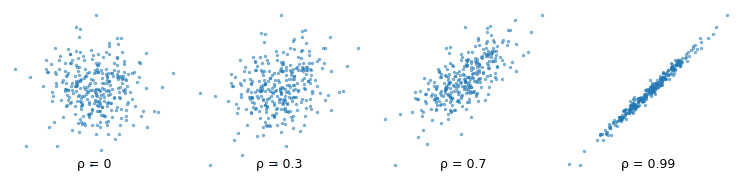

<IPython.core.display.Javascript object>

In [40]:
from thinkstats import make_correlated_scatter

plt.figure(figsize=(10, 2.5))

for i, rho in enumerate([0, 0.3, 0.7, 0.99]):
    plt.subplot(1, 4, i + 1)
    make_correlated_scatter(xs, ys, rho)
decorate()

The Greek letter ρ, which is spelled "rho" and pronounced like "row", is the conventional symbol for the correlation coefficient.

Correlation can also be negative.
Here are scatter plots for random data with a range of negative correlations

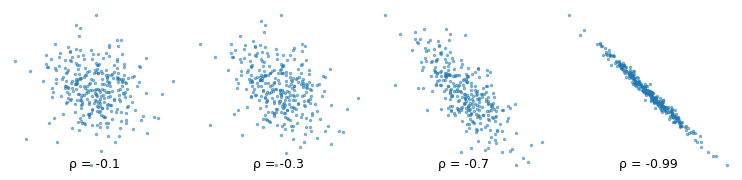

<IPython.core.display.Javascript object>

In [41]:
plt.figure(figsize=(10, 2.5))

for i, rho in enumerate([-0.1, -0.3, -0.7, -0.99]):
    plt.subplot(1, 4, i + 1)
    make_correlated_scatter(xs, ys, rho)
decorate()

The correlation coefficient is always between -1 and 1.
If there is no relationship between two variables, their correlation is 0 -- but if the correlation is 0, that doesn't necessarily mean there is no relationship.

In particular, if there is a non-linear relationship, the correlation coefficient can be close to 0.
In each of the following examples, there is a clear relationship between the variables in the sense that if we are given one of the values, we can make a substantially better prediction of the other.
But in each case the correlation coefficient is close to 0.

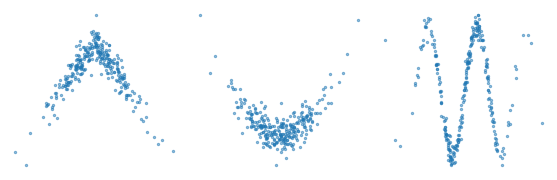

<IPython.core.display.Javascript object>

In [42]:
from thinkstats import make_nonlinear_scatter

plt.figure(figsize=(10, 2.5))

for i, kind in enumerate(["abs", "quadratic", "sinusoid"]):
    plt.subplot(1, 4, i + 1)
    make_nonlinear_scatter(xs, ys, kind)
decorate()

The important thing to remember is that correlation quantifies the strength of a *linear* relationship between variables.
If there is a non-linear relationship, the correlation coefficient can be misleading.
And if the correlation is close to 0, that does *not* mean there is no relationship.

## Rank Correlation


The NLSY is longitudinal, which means that it follows the same group of people over time.
The group we've been studying includes people born between 1980 and 1984.
The ones who took the SAT probably took it in the late 1990s, when they were about 18 years old.
So when they were asked about their income in 2021, they were in their late 30s or early 40s.

Let's give the column with the income data a more interpretable name.

In [111]:
nlsy["income"] = nlsy["U4949700"]
nlsy["income"].describe()

count      6051.000000
mean     104274.239960
std      108470.571497
min           0.000000
25%       38000.000000
50%       80000.000000
75%      134157.000000
max      599728.000000
Name: income, dtype: float64

<IPython.core.display.Javascript object>

The values in this column are gross family income, which is total income from all sources of the respondent and the other members of their household, reported in U.S. dollars (USD).
Here's what the distribution of income looks like.

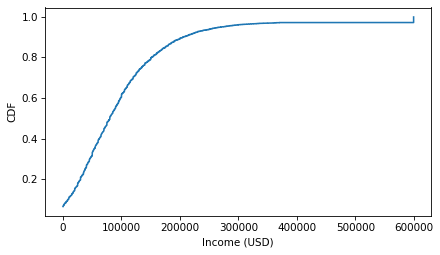

<IPython.core.display.Javascript object>

In [44]:
from empiricaldist import Cdf

cdf_income = Cdf.from_seq(nlsy["income"])
cdf_income.step()

decorate(xlabel="Income (USD)", ylabel="CDF")

Notice the step near $600,000 -- values above this threshold were capped to protect the anonymity of the participants.
Now here's a scatter plot of the respondents' SAT math scores and their income later in life.

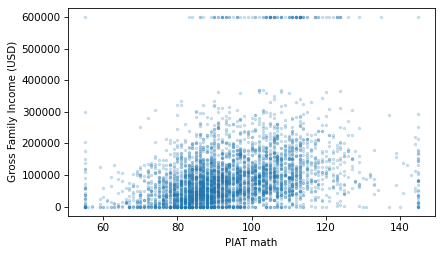

<IPython.core.display.Javascript object>

In [45]:
scatter(nlsy, "piat_math", "income")

decorate(xlabel="PIAT math", ylabel="Gross Family Income (USD)")

It looks like there is a relationship between these variables.
Here is the correlation.

In [46]:
corrcoef(nlsy, "piat_math", "income")

0.30338587288641233

<IPython.core.display.Javascript object>

The correlation is about 0.3, which means that if someone gets a PIAT math score one standard deviation above the mean when they are 15 years old, we expect their income to be about 0.3 standard deviations above the mean when they are 40.
That's not as strong as the correlation between PIAT scores and SAT scores, but considering the number of factors that affect income, it's pretty strong.

In fact, Pearson's correlation coefficient might understate the strength of the relationship.
As we can see in the previous scatter plot, both variables have an apparent excess of values at the extremes.
Because the correlation coefficient is based on the product of deviations from the mean, it is sensitive to these extreme values.

A more robust alternative is the **rank correlation**, which is based on the ranks of the scores rather than standardized scores.
We can use the Pandas method `rank` to compute the rank of each score and each income.

In [117]:
nlsy["piat_math_rank"] = nlsy["piat_math"].rank(method="first")
nlsy["income_rank"] = nlsy["income"].rank(method="first")

<IPython.core.display.Javascript object>

The results for both variables are ranks from 1 to 6051

In [122]:
nlsy["income_rank"].min(), nlsy["income_rank"].max()

(1.0, 6051.0)

<IPython.core.display.Javascript object>

Here's a scatter plot of the ranks.

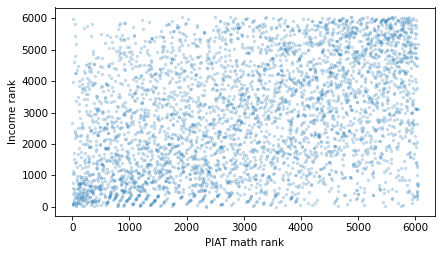

<IPython.core.display.Javascript object>

In [120]:
scatter(nlsy, "piat_math_rank", "income_rank")

decorate(xlabel="PIAT math rank", ylabel="Income rank")

And here's the correlation of the ranks.

In [121]:
corrcoef(nlsy, "piat_math_rank", "income_rank")

0.3814091858940045

<IPython.core.display.Javascript object>

The result is about 0.38, somewhat higher than the Pearson correlation, which is 0.3.
Because rank correlation is less sensitive to the effect of extreme values, it is probably a better measure of the strength of the relationship between these variables.

As an exercise, you'll have a chance to compute the correlation between SAT verbal scores and income, both Pearson's correlation and the rank correlation.

## Correlation and causation

If variables A and B are correlated, there are three possible explanations: A causes B, or B causes A, or some other set of factors causes both A and B. These explanations are called "causal relationships".

Correlation alone does not distinguish between these explanations, so it does not tell you which ones are true.
This rule is often summarized with the phrase "Correlation does not imply causation," which is so pithy it has its own Wikipedia page.

<http://wikipedia.org/wiki/Correlation_does_not_imply_causation>

So what can you do to provide evidence of causation?

1.  Use time. If A comes before B, then A can cause B but not the other way around.
The order of events can help us infer the direction of causation, but it does not preclude the possibility that something else causes both A and B.

2.  Use randomness.
If you divide a large sample into two groups at random and compute the means of almost any variable, you expect the difference to be small.
If the groups are nearly identical in all variables but one, you can eliminate spurious relationships.

These ideas are the motivation for the **randomized controlled trial**, in which subjects are assigned randomly to two (or more) groups: a **treatment group** that receives some kind of intervention, like a new medicine, and a **control group** that receives no intervention, or another treatment whose effects are known.
A randomized controlled trial is the most reliable way to demonstrate a causal relationship, and the foundation of science-based medicine.

Unfortunately, controlled trials are only possible in the laboratory sciences, medicine, and a few other disciplines.
In the social sciences, controlled experiments are rare, usually because they are impossible or unethical.
An alternative is to look for a **natural experiment**, where similar groups are exposed to different conditions due to circumstances beyond the control of the experimenter.

Identifying and measuring causal relationships is the topic of a branch of statistics called **causal inference**.

## Glossary

-   **scatter plot**: A visualization of the relationship between two variables, showing one point for each row of data.

-   **jitter**: Random noise added to data for purposes of visualization.

-   **saturation**: Loss of information when multiple points are plotted on top of each other.

-   **correlation**: A statistic that measures the strength of the relationship between two variables.

-   **standardize**: To transform a set of values so that their mean is 0 and their variance is 1.

-   **standard score**: A value that has been standardized so that it is expressed in standard deviations from the mean.

-   **covariance**: A measure of the tendency of two variables to vary together.

-   **rank**: The index where an element appears in a sorted list.

-   **randomized controlled trial**: An experimental design in which subjects are divided into groups at random, and different groups are given different treatments.

-   **treatment group**: A group in a controlled trial that receives some kind of intervention.

-   **control group**: A group in a controlled trial that receives no treatment, or a treatment whose effect is known.

-   **natural experiment**: An experimental design that takes advantage of a natural division of subjects into groups in ways that are at least approximately random.

## Exercises

### Exercise



In [97]:
missing_codes = [-6, -7, -8, -9]
nlsy["gpa"] = nlsy["R9871900"].replace(missing_codes, np.nan) / 100
nlsy["gpa"].describe()

count    6004.000000
mean        2.818408
std         0.616357
min         0.100000
25%         2.430000
50%         2.860000
75%         3.260000
max         4.170000
Name: gpa, dtype: float64

<IPython.core.display.Javascript object>

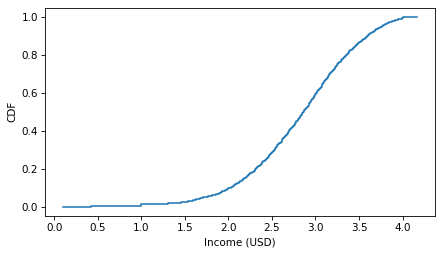

<IPython.core.display.Javascript object>

In [98]:
cdf_income = Cdf.from_seq(nlsy["gpa"])
cdf_income.step()
decorate(xlabel="Income (USD)", ylabel="CDF")

In [96]:
nlsy["sat_total"] = nlsy["sat_verbal"] + nlsy["sat_math"]
nlsy["sat_total"].describe()

count    1398.000000
mean     1004.892704
std       203.214916
min       430.000000
25%       860.000000
50%      1000.000000
75%      1140.000000
max      1580.000000
Name: sat_total, dtype: float64

<IPython.core.display.Javascript object>

In [101]:
corrcoef(nlsy, "gpa", "sat_total")

0.49151202115123105

<IPython.core.display.Javascript object>

In [100]:
corrcoef(nlsy, "gpa", "income")

0.2769331736366622

<IPython.core.display.Javascript object>

In [102]:
nlsy["sex"] = nlsy["R0536300"]
nlsy["sex"].value_counts()

sex
1    4599
2    4385
Name: count, dtype: int64

<IPython.core.display.Javascript object>

In [104]:
corrcoef(nlsy.query("sex == 1"), "gpa", "sat_total")

0.5370919853275717

<IPython.core.display.Javascript object>

In [105]:
corrcoef(nlsy.query("sex == 2"), "gpa", "sat_total")

0.4909916575472292

<IPython.core.display.Javascript object>

In [106]:
corrcoef(nlsy.query("sex == 1"), "gpa", "income")

0.26896499010590313

<IPython.core.display.Javascript object>

In [107]:
corrcoef(nlsy.query("sex == 2"), "gpa", "income")

0.3040642590135165

<IPython.core.display.Javascript object>

### Exercise

Income versus education

In [53]:
xvar = "Z9083900"
yvar = "U4949700"

<IPython.core.display.Javascript object>

In [54]:
valid = nlsy.dropna(subset=[xvar, yvar])
valid[xvar].describe()

count    6028.000000
mean        2.634041
std         1.520432
min         0.000000
25%         2.000000
50%         2.000000
75%         4.000000
max         7.000000
Name: Z9083900, dtype: float64

<IPython.core.display.Javascript object>

In [55]:
positions = [0, 1, 2, 3, 4, 5, 6, 7]
labels = [
    'None', 
    'GED', 
    'High school diploma', 
    "Associate's degree", 
    "Bachelor's degree", 
    "Master's degree", 
    'PhD', 
    'Professional degree'
]


<IPython.core.display.Javascript object>

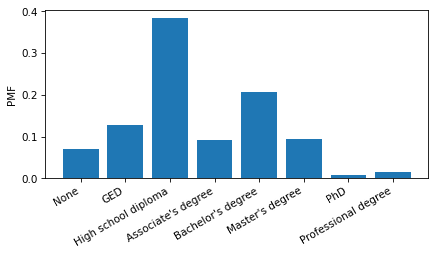

<IPython.core.display.Javascript object>

In [56]:
from empiricaldist import Pmf

Pmf.from_seq(valid[xvar]).bar()

plt.xticks(positions, labels, rotation=30, ha="right")
decorate(ylabel="PMF")

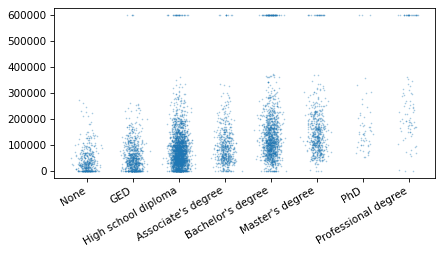

<IPython.core.display.Javascript object>

In [57]:
xs = jitter(valid[xvar], 0.1)
plt.plot(xs, valid[yvar], ".", ms=1, alpha=0.4)

plt.xticks(positions, labels, rotation=30, ha="right")
decorate()

In [58]:
np.corrcoef(valid[xvar], valid[yvar])

array([[1.        , 0.40973088],
       [0.40973088, 1.        ]])

<IPython.core.display.Javascript object>

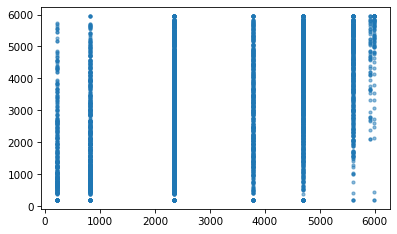

<IPython.core.display.Javascript object>

In [59]:
x_ranks = valid[xvar].rank()
y_ranks = valid[yvar].rank()

plt.plot(x_ranks, y_ranks, ".", alpha=0.5)


In [60]:
np.corrcoef(x_ranks, y_ranks)

array([[1.        , 0.47941203],
       [0.47941203, 1.        ]])

<IPython.core.display.Javascript object>

**Exercise:**  So far we have been working with a subset of only 5000 respondents.
When we include the entire dataset, making an effective scatter plot can be tricky.
As an exercise, experiment with `scatter` and `hex_bin` to make a plot that represents the entire dataset well.

In [61]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/CDBRFS08.ASC.gz")

<IPython.core.display.Javascript object>

In [62]:
from thinkstats import read_brfss

brfss = read_brfss()

<IPython.core.display.Javascript object>

In [63]:
# Solution

from thinkstats import jitter

heights_jittered = jitter(brfss["htm3"], 2.8)
weights_jittered = jitter(brfss["wtkg2"], 1.0)

<IPython.core.display.Javascript object>

CPU times: user 18.8 ms, sys: 0 ns, total: 18.8 ms
Wall time: 18 ms


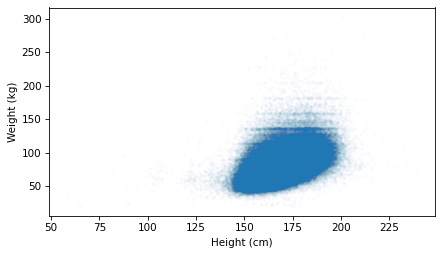

<IPython.core.display.Javascript object>

In [64]:
%time plt.plot(heights_jittered, weights_jittered, "o", ms=2, alpha=0.01)
decorate(xlabel="Height (cm)", ylabel="Weight (kg)")

CPU times: user 26.1 ms, sys: 4.87 ms, total: 31 ms
Wall time: 29.5 ms


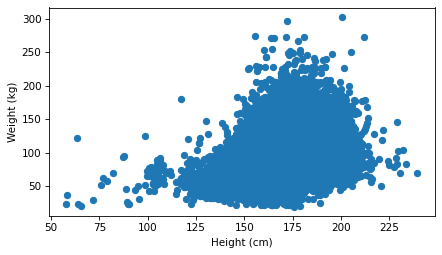

<IPython.core.display.Javascript object>

In [65]:
%time plt.scatter(heights_jittered, weights_jittered)
decorate(xlabel="Height (cm)", ylabel="Weight (kg)")

**Exercise:** Yet another option is to divide the dataset into groups and then plot the CDF for each group.
As an exercise, divide the dataset into a smaller number of groups and plot the CDF for each group.

In [66]:
# Solution

cleaned = df.dropna(subset=["htm3", "wtkg2"])

NameError: name 'df' is not defined

<IPython.core.display.Javascript object>

In [ ]:
# Solution

bins = np.arange(140, 210, 10)
indices = np.digitize(cleaned['htm3'], bins)
groups = cleaned.groupby(indices)
cdfs = [Cdf.from_seq(group.wtkg2, name=i) for i, group in groups]

for cdf in cdfs:
    cdf.plot()
decorate(xlabel="Weight (kg)", ylabel="CDF")

Using data from the NSFG, make a scatter plot of birth weight versus mother’s age.
Plot percentiles of birth weight versus mother’s age.
Compute Pearson’s and Spearman’s correlations.
How would you characterize the relationship between these variables?

In [ ]:
download("https://github.com/AllenDowney/ThinkStats/raw/v3/nb/nsfg.py")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dct")
download("https://github.com/AllenDowney/ThinkStats/raw/v3/data/2002FemPreg.dat.gz")

In [ ]:
import nsfg

live, firsts, others = nsfg.make_frames()
live = live.dropna(subset=["agepreg", "totalwgt_lb"])

In [ ]:
# Solution

ages = live.agepreg
weights = live.totalwgt_lb
print("corr", corr(ages, weights))
print("spearman_corr", spearman_corr(ages, weights))

In [ ]:
# Solution


def binned_percentiles(df):
    """Bin the data by age and plot percentiles of weight for each bin.

    df: DataFrame
    """
    bins = np.arange(10, 48, 3)
    indices = np.digitize(df.agepreg, bins)
    groups = df.groupby(indices)
    ages = [group.agepreg.mean() for i, group in groups][1:-1]
    cdfs = [Cdf.from_seq(group.totalwgt_lb) for i, group in groups][1:-1]

    for percent in [0.75, 0.50, 0.25]:
        weights = [cdf.inverse(percent) for cdf in cdfs]
        label = "%dth" % percent
        plt.plot(ages, weights, label=label)

    decorate(
        xlabel="Mother's age (years)",
        ylabel="Birth weight (lbs)",
        xlim=[14, 45],
        legend=True,
    )


binned_percentiles(live)

In [ ]:
# Solution

plt.scatter(ages, weights, alpha=0.05, s=10)
decorate(
    xlabel="Age (years)",
    ylabel="Birth weight (lbs)",
    xlim=[10, 45],
    ylim=[0, 15],
)